# LSTM 

In [72]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import xarray as xr
from itertools import product
from tqdm.auto import tqdm

# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from lstm import WindowedTimeSeries, train_model, predict_one_step, predict_autoregressive, evaluate_model

In [73]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [74]:
series = generate_data(10000, noise_level=0.05)
train_series = series[:8000, :]
val_series = series[8000:9000, :]
test_series = series[9000:, :]
train_series.shape

(8000, 3)

In [75]:
train_dataset = WindowedTimeSeries(train_series, seq_length=10)
val_dataset = WindowedTimeSeries(val_series, seq_length=10)
test_dataset = WindowedTimeSeries(test_series, seq_length=10)

In [76]:
model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=100,
  patience=10,
  device=device)

Epoch [10/100], train_loss: 1.1226, val_loss: 1.0596
Epoch [20/100], train_loss: 1.1722, val_loss: 1.0135
Early stopping triggered at epoch: 24


In [77]:
evaluate_model(model, test_dataset)

1.116756558418274

## LSTM Using Direct Predictions

In [78]:
train_dataset = WindowedTimeSeries(train_series, seq_length=10, horizon=20)
val_dataset = WindowedTimeSeries(val_series, seq_length=10, horizon=20)

In [79]:
model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=100,
  patience=100)

Epoch [10/100], train_loss: 39.7456, val_loss: 43.0905
Epoch [20/100], train_loss: 26.4932, val_loss: 35.7172
Epoch [30/100], train_loss: 22.3825, val_loss: 27.3472
Epoch [40/100], train_loss: 21.5142, val_loss: 27.1573
Epoch [50/100], train_loss: 18.9339, val_loss: 24.9859
Epoch [60/100], train_loss: 18.9133, val_loss: 23.7493
Epoch [70/100], train_loss: 17.1640, val_loss: 24.5098
Epoch [80/100], train_loss: 17.2773, val_loss: 22.4474
Epoch [90/100], train_loss: 17.4453, val_loss: 23.2246
Epoch [100/100], train_loss: 17.1396, val_loss: 22.8349


In [66]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_preds = []
all_target = []

for X_batch, Y_batch in test_loader:   # Ignore targets
    preds = predict_autoregressive(model, X_batch, steps=1)
    all_preds.append(preds)
    all_target.append(Y_batch)

all_preds = torch.cat(all_preds)
all_target = torch.cat(all_target)
nn.MSELoss()(all_preds[10:,:], all_target[10:,:])

tensor(30.4477)

In [ ]:
# steps = [1,5,10,15,20]
steps = np.arange(1,21)
MSE = np.zeros((len(steps)))

for i, step in enumerate(steps):
  train_dataset = WindowedTimeSeries(train_series, seq_length=10, horizon=step)
  val_dataset = WindowedTimeSeries(val_series, seq_length=10, horizon=step)
  test_dataset = WindowedTimeSeries(test_series, seq_length=10, horizon=step)  

  model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=100,
  patience=10,
  silence=True,
  device=torch.device("mps"))

  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
  
  all_preds = []
  all_target = []
  for X_batch, Y_batch in test_loader:
    preds = predict_autoregressive(model, X_batch)
    all_preds.append(preds)
    all_target.append(Y_batch)


  all_preds = torch.cat(all_preds)
  all_target = torch.cat(all_target)
  

  mse = nn.MSELoss()(all_preds, all_target)
  MSE[i] = mse
  print(f"{step} Steps, MSE: {mse}")

In [27]:
ds = xr.Dataset(
  data_vars=dict(
    mse=(["k"], MSE),
  ),
  coords=dict(
    k=steps,
  ),
  attrs=dict(
    time_step=0.05,
    description="MSE of LSTM",
  )
)

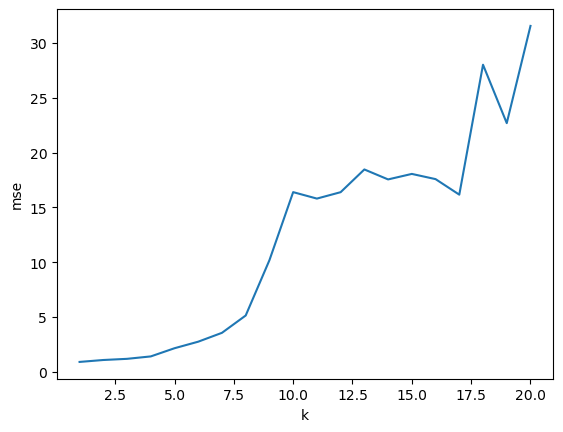

In [28]:
ds.mse.plot(x="k")


In [30]:
out_path = Path("../data/processed/mse_LSTM.nc")

ds.to_netcdf(out_path)

# Training LSTMs with different hidden sizes

In [42]:
hidden_sizes = np.arange(2,42,2)
k_range = [5,10,15]
configs = list(product(hidden_sizes, k_range))

In [30]:
mse = xr.DataArray(
    np.full(
        (len(hidden_sizes), len(k_range)),
        np.nan,
    ),
    dims=("hidden_size", "k"),
    coords={
        "hidden_size": hidden_sizes,
        "k": k_range,},
    name="mse",
)

In [41]:
ds = xr.Dataset(
    {
        "mse": (("k", "hidden_size"),
                np.full((len(k_range), len(hidden_sizes)), np.nan))
    },
    coords={
        "k": k_range,
        "data_size": hidden_sizes
    }
)

In [ ]:
pbar = tqdm(configs, desc="Hyperparameter Sweep", colour="green")

for h, k in pbar:
  train_dataset = WindowedTimeSeries(train_series, seq_length=10, horizon=k)
  val_dataset = WindowedTimeSeries(val_series, seq_length=10, horizon=k) 
  test_dataset = WindowedTimeSeries(test_series, seq_length=10, horizon=k)

  device = torch.device("mps") if h >= 25 else torch.device("cpu")
 
  model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=int(h),
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=100,
  patience=100,
  silence=True,
  device=device)

  mse = evaluate_model(model, test_dataset)

  ds["mse"].loc[dict(hidden_size=h,k=k)] = mse

  pbar.set_postfix(mse=f"{mse:.2f}", h=h, k=k)

In [ ]:
ds["mse"].sel(k=5).plot()

In [ ]:
out_path = Path("../data/processed/mse_LSTM_h-range.nc")
ds.attrs["patience"] = 100

ds.to_netcdf(out_path)

# LSTM Over range of data sizes

In [47]:
k_range = [5,10,15]
data_size_range = np.arange(100,2001,100)
configs = list(product(k_range, data_size_range))

In [48]:
ds = xr.Dataset(
    {
        "mse": (("k", "data_size"),
                np.full((len(k_range), len(data_size_range)), np.nan))
    },
    coords={
        "k": k_range,
        "data_size": data_size_range
    }
)

In [66]:
pbar = tqdm(configs, desc="Hyperparameter Sweep", colour="green")

for k, size in pbar:
  train_series_short = train_series[:size,]
  val_series_new = series[4000:5000, :]
  test_series_new = series[7000:, :]

  train_dataset = WindowedTimeSeries(train_series_short, seq_length=10, horizon=k)
  val_dataset = WindowedTimeSeries(val_series_new, seq_length=10, horizon=k) 
  test_dataset = WindowedTimeSeries(test_series_new, seq_length=10, horizon=k)

  model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=300,
  silence=True,
  patience=300,
  device=torch.device("mps"))

  mse = evaluate_model(model, test_dataset)

  ds["mse"].loc[dict(data_size=size,k=k)] = mse

  pbar.set_postfix(mse=f"{mse:.2f}", size=size, k=k)
  

Hyperparameter Sweep:   0%|          | 0/60 [00:00<?, ?it/s]

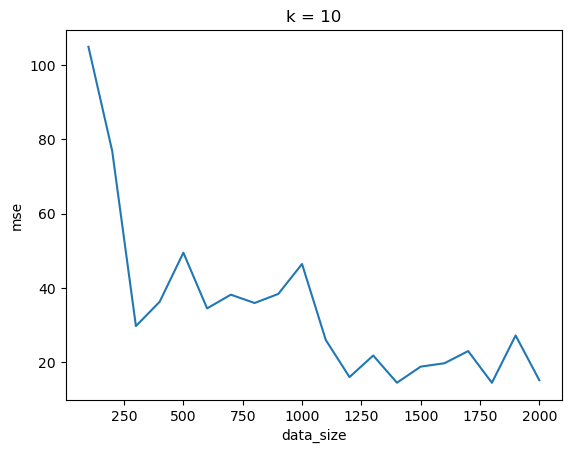

In [70]:
ds["mse"].sel(k=10).plot()

In [71]:
out_path = Path("../data/processed/mse_LSTM_d-range.nc")

ds.attrs["patience"] = 300
ds.attrs["epochs"] = 300
ds.attrs["test_size"] = 3000

ds.to_netcdf(out_path)